# Tutorial 3 – Advanced reaction systems with additional states

It is also possible to combine additional complementary states, equations and variables into a KIPET model. In the example labeled “Ex_3_complementary.py” an example is solved that includes a temperature and volume change.

### Load required modules

In [5]:
import sys

import matplotlib.pyplot as plt
from pyomo.core import *

from kipet.library.TemplateBuilder import *
from kipet.library.PyomoSimulator import *

In this example the model is defined in the same way as was shown before, however this time complementary state variable temperature is added using the following KIPET function:


In [6]:
builder = TemplateBuilder()    
builder.add_mixture_component('A',1.0)
builder.add_mixture_component('B',0.0)
builder.add_mixture_component('C',0.0)

# Complemetary states added here:
builder.add_complementary_state_variable('T',290.0)
builder.add_complementary_state_variable('V',100.0)

This function now adds additional variables to the model, labeled “X”. This same formulation can be used to add any sort of additional complementary state information to the model. Now, similarly to with the components, each complementary state will require an ODE to accompany it. In the case of this tutorial example the following ODEs are defined:

In [7]:
def rule_odes(m,t):
    k1 = 1.25*exp((9500/1.987)*(1/320.0-1/m.X[t,'T']))
    k2 = 0.08*exp((7000/1.987)*(1/290.0-1/m.X[t,'T']))
    ra = -k1*m.Z[t,'A']
    rb = 0.5*k1*m.Z[t,'A']-k2*m.Z[t,'B']
    rc = 3*k2*m.Z[t,'B']
    cao = 4.0
    vo = 240
    T1 = 35000*(298-m.X[t,'T'])
    T2 = 4*240*30.0*(m.X[t,'T']-305.0)
    T3 = m.X[t,'V']*(6500.0*k1*m.Z[t,'A']-8000.0*k2*m.Z[t,'B'])
    Den = (30*m.Z[t,'A']+60*m.Z[t,'B']+20*m.Z[t,'C'])*m.X[t,'V']+3500.0
    exprs = dict()
    exprs['A'] = ra+(cao-m.Z[t,'A'])/m.X[t,'V']
    exprs['B'] = rb-m.Z[t,'B']*vo/m.X[t,'V']
    exprs['C'] = rc-m.Z[t,'C']*vo/m.X[t,'V']
    exprs['T'] = (T1+T2+T3)/Den
    exprs['V'] = vo
    return exprs

builder.set_odes_rule(rule_odes)

# Then we can create an instance of a pyomo model template as before    
pyomo_model = builder.create_pyomo_model(0.0,2.0)

Where “m.X[t,'V']” and “m.X[t,'T']” are the additional state variables and “m.Z[t,component]” is the concentration of the component at time t. We can then simulate the model (or use experimental data if available and estimate the parameters) in the same way as described in the previous examples. Please follow the rest of the code and run the examples to obtain the output.

In [8]:
# create instance of simulator since we wish to simulate the system
simulator = PyomoSimulator(pyomo_model)

# define the discretization scheme for the concentration and temperature profiles
simulator.apply_discretization('dae.collocation',nfe=20,ncp=1,scheme='LAGRANGE-RADAU')

# simulate
results_pyomo = simulator.run_sim('ipopt',tee=True)

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.13.2, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:      725
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      300

Total number of variables............................:      205
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      205
Total number of ineq

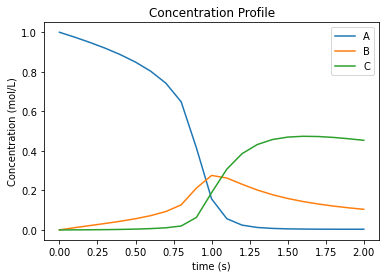

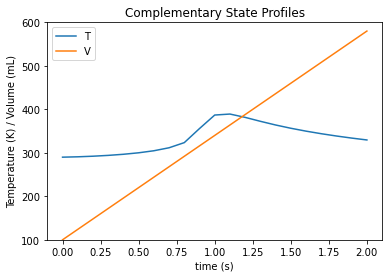

In [11]:
results_pyomo.Z.plot.line(legend=True)
plt.xlabel("time (s)")
plt.ylabel("Concentration (mol/L)")
plt.title("Concentration Profile")


results_pyomo.X.plot.line(legend=True)
plt.ylim([100,600])
plt.xlabel("time (s)")
plt.ylabel("Temperature (K) / Volume (mL)")
plt.title("Complementary State Profiles")

plt.show()